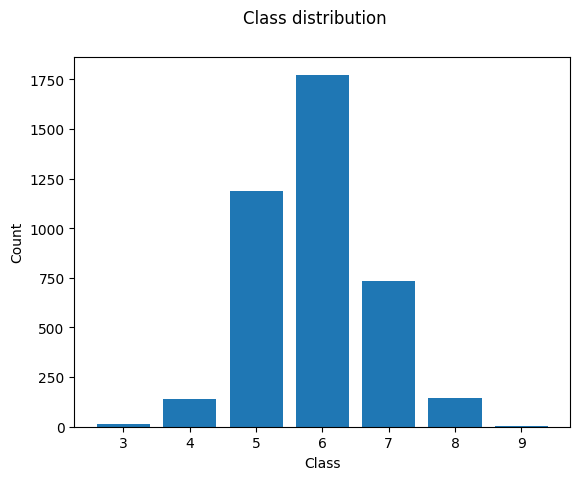

X data head:
           0         1         2         3         4         5         6  \
0  0.233449  0.166667  0.381818  0.424594  0.164110  0.354839  0.250000   
1  0.160279  0.196078  0.263636  0.262181  0.176380  0.161290  0.346154   
2  0.083624  0.156863  0.300000  0.396752  0.191718  0.177419  0.355769   
3  0.097561  0.107843  0.390909  0.201856  0.019939  0.451613  0.288462   
4  0.073171  0.411765  0.445455  0.271462  0.007669  0.467742  0.413462   

          7         8         9  
0  0.325581  0.166184  0.192771  
1  0.255814  0.196453  0.301205  
2  0.360465  0.226141  0.186747  
3  0.372093  0.088490  0.216867  
4  0.232558  0.128976  0.283133  
X data statistics:
                  0            1            2            3            4  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean      0.116510     0.195335     0.425750     0.300546     0.089198   
std       0.059493     0.099523     0.136702     0.098385     0.078084   
min       0.000

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('MLoGPU_data1_train.csv', header=None)

# Plot a histogram of the class distribution
y = data.iloc[:, -1]
X = data.iloc[:, :-1]
counts = y.value_counts()
fig, ax = plt.subplots()
ax.bar(counts.index, counts)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
fig.suptitle('Class distribution')
plt.show()

print(f"X data head:\n {X.head()}")

print(f"X data statistics:\n {X.describe()}")

print(f"X missing values:\n {X.isnull().sum()}")


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Shift y to start from 0, so reduce each value by 3
y = y - 3
# Convert y to be one-hot encoded, so for example 0 -> [1, 0, 0, 0, 0, 0, 0], or 6 -> [0, 0, 0, 0, 0, 0, 1]
y = pd.get_dummies(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
assert y_train.shape[1] == y_test.shape[1] == 7

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print the shape of the data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3200, 10)
y_train shape: (3200, 7)
X_test shape: (800, 10)
y_test shape: (800, 7)


Using device: cuda
Model:
 MLP(
  (fc1): Linear(in_features=10, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=7, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
Output shape: torch.Size([3200, 7])
First 5 outputs:
 tensor([[0.1653, 0.1597, 0.1491, 0.1504, 0.1287, 0.1102, 0.1366],
        [0.1793, 0.1418, 0.1482, 0.1548, 0.1273, 0.1034, 0.1452],
        [0.1719, 0.1760, 0.1539, 0.1518, 0.1178, 0.0860, 0.1427],
        [0.1609, 0.1556, 0.1536, 0.1520, 0.1266, 0.1114, 0.1399],
        [0.1564, 0.1429, 0.1490, 0.1505, 0.1321, 0.1235, 0.1455]],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor(1.9436, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 0: Train loss: 1.944, Test loss: 1.944
Epoch 50: Train loss: 1.892, Test loss: 1.891
Epoch 100: Train loss: 1.771, Test loss: 1.769
Epoch 150: Train loss: 1.706, Test loss: 1.709
Epoch 200: Train loss: 1.683, Test loss: 1.69
Epoch 250: Train los

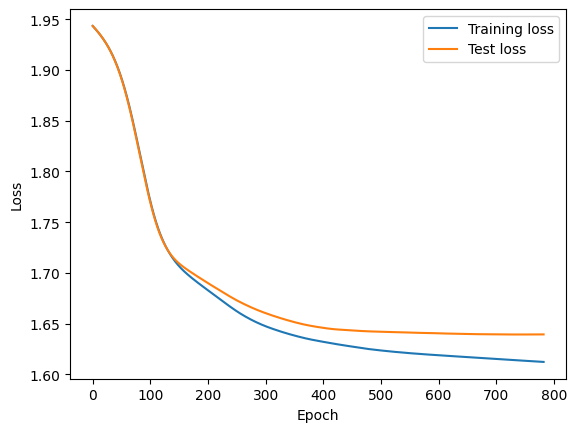

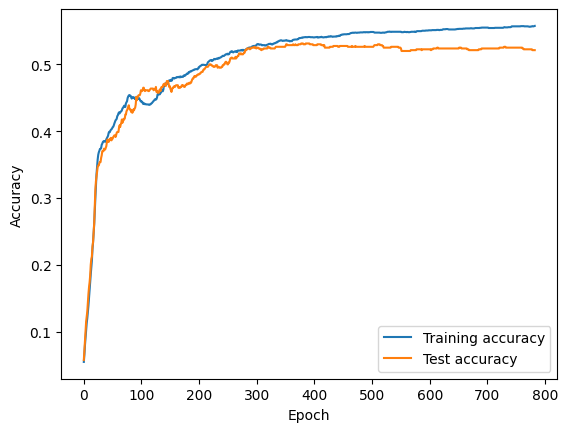

In [5]:
import torch

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model = MLP(input_dim=X_train.shape[1],
            hidden_dim=12,
            output_dim=y_train.shape[1]).to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train.values).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test.values).to(device)

print(f"Model:\n", model)
out = model(X_train)
print(f"Output shape: {out.shape}")
print(f"First 5 outputs:\n {out[:5]}")
out_loss = criterion(out, y_train.clone().detach())
print(out_loss)

# Train the model
n_epochs = 1000
patience = 50

train_losses = []
test_losses = []
test_accs = []
train_accs = []
best_loss = float('inf')

for epoch in range(n_epochs):
    model.train()
    optim.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optim.step()
    train_losses.append(loss.item())
    model.eval()
    
    # The accuracy is the mean of a list of 1s and 0s where 1 is correct and 0 is incorrect
    train_acc = (out.argmax(dim=1) == y_train.argmax(dim=1)).float().mean().item()
    train_accs.append(train_acc)
    with torch.no_grad():
        out = model(X_test)
        loss = criterion(out, y_test)
        test_losses.append(loss.item())
        test_acc = (out.argmax(dim=1) == y_test.argmax(dim=1)).float().mean().item()
        test_accs.append(test_acc)
        
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train loss: {round(train_losses[-1],3)}, Test loss: {round(test_losses[-1],3)}")

# Plot the losses
fig, ax = plt.subplots()
ax.plot(train_losses, label='Training loss')
ax.plot(test_losses, label='Test loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots()
ax.plot(train_accs, label='Training accuracy')
ax.plot(test_accs, label='Test accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

